# **Real-World Example: Parallel Context Gathering and Answer Generation**

In this project, two sources (Wikipedia and Web Search) are queried in parallel for context, and then a question-answering model combines these contexts to generate an answer.

**Context Gathering:**

* search_web and search_wikipedia nodes fetch relevant documents in parallel.

* **Wikipedia Loader:** Retrieves pages from Wikipedia.

* **Tavily Web Search:** Fetches web pages relevant to the question.

**Answer Generation:**

* The generate_answer node receives context from both sources and uses a language model to provide a well-rounded answer.

* **LLM Interaction:** Uses a language model to answer based on the combined context.

### **Set up Everything:**

In [2]:
%%capture --no-stderr
%pip install -qU langgraph langchain-google-genai langchain_core langchain_community tavily-python wikipedia langgraph_sdk

In [3]:
# For Colab, use this:
from google.colab import userdata
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")
TAVILY_API_KEY = userdata.get("TAVILY_API_KEY")

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

gemini_flash: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model='gemini-1.5-flash',
    temperature=0,
    api_key=GEMINI_API_KEY
)

In [5]:
import os
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [6]:
from typing import Annotated
from typing_extensions import TypedDict
import operator

class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

### **search_web:** Retrieves documents related to a given question from a web search (using Tavily)

In [7]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults

def search_web(state):

    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

**Purpose:** This function performs a web search using Tavily based on a question provided in state. It formats the search results for easier display or processing.

**Components:**

* **TavilySearchResults(max_results=3):** This initializes a Tavily search object, configured to return up to 3 results.

* **tavily_search.invoke(state['question']):** Here, invoke is called with the question to perform the search. It returns a list of documents, each containing url and content fields.

**Formatting:**

* The results are formatted into a string using a list comprehension and join. Each document's URL and content are wrapped in <Document> tags for readability and structure.

* The formatted_search_docs variable stores the formatted string, which is later returned in the dictionary {"context": [formatted_search_docs]}. This dictionary structure allows other parts of the program to access the formatted search context.

### **search_wikipedia:** Retrieves documents from Wikipedia related to the same question.

In [8]:
def search_wikipedia(state):

    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['question'],
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

**Purpose:** This function uses WikipediaLoader to retrieve content from Wikipedia based on the same question.

**Components:**

* **WikipediaLoader(query=state['question'], load_max_docs=2):** Initializes a loader to search Wikipedia for the question and limit the results to 2 documents.

* **.load():** Executes the search and retrieves the documents. Each document contains metadata and page content.

**Formatting:**

* Like search_web, this function formats the Wikipedia results in <Document> tags with metadata fields (source and page).

* formatted_search_docs is then wrapped in a dictionary under the context key.

### **generate_answer:** Generates a response based on the information retrieved from Tavily and Wikipedia, using the gemini_flash model.

In [9]:
def generate_answer(state):

    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question,
                                                       context=context)

    # Answer
    answer = gemini_flash.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])

    # Append it to state
    return {"answer": answer}

**Purpose:** This function generates a response to the question by combining context from both the Tavily and Wikipedia results.

**Components:**

* The answer_template defines a prompt to ask the AI model a question based on the combined context.

* answer_instructions is created by filling in the question and context values from state.

**Generating the Answer:**

**gemini_flash.invoke(...):** This line calls the gemini_flash model (an instance of ChatGoogleGenerativeAI) with the prompt. The input to invoke includes:

* **SystemMessage(content=answer_instructions):** Instructs the model on the context.

* **HumanMessage(content="Answer the question."):** Simulates a human asking the question directly, prompting the model to answer.

**Returning the Answer:**
* The answer generated by the model is returned in a dictionary, {"answer": answer}, which can be used in the graph's flow.

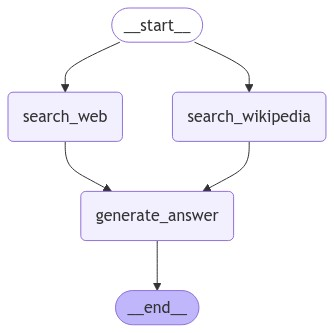

In [10]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
result = graph.invoke({"question": "what is today's news regarding elections happening in the US"})
answer = result['answer'].content

print(answer)

Please provide me with the question you would like me to answer. I need the question to understand what information from the provided context is relevant. 

